# 读取pickle数据

In [83]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from load_LIDC_data import LIDC_IDRI
# from probabilistic_unet import ProbabilisticUnet
# from utils import l2_regularisation
from save_load_net import save_model, load_model


#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = LIDC_IDRI(dataset_location = 'data/')

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.1 * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=5, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=1, sampler=test_sampler)
print("Number of training/test patches:", (len(train_indices),len(test_indices)))

Loading file data_lidc.pickle
Number of training/test patches: (67932, 7548)


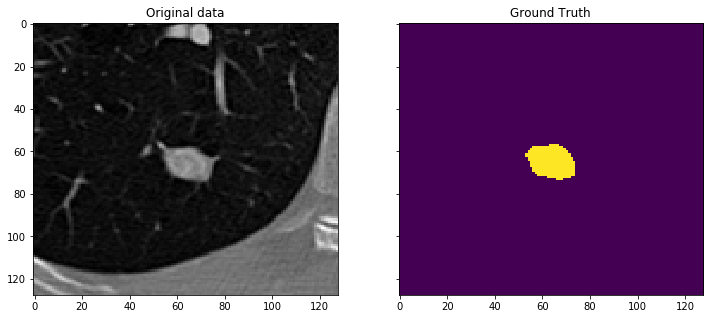

In [85]:
image, label, series_uid = dataset.__getitem__(0)
# image, label, series_uid
# print(len(image),len(image[0]),len(image[0][0]))

image_np = image.numpy()[0]
label_np = label.numpy()

fig, ax = plt.subplots(1,2, sharey=True, figsize=(12,5))
ax[0].set_title("Original data")
ax[1].set_title("Ground Truth")
ax[0].imshow(image_np, aspect="auto",  cmap="gray" )
# ax[0].imshow(image_np, aspect="auto")
ax[1].imshow(label_np, aspect="auto")

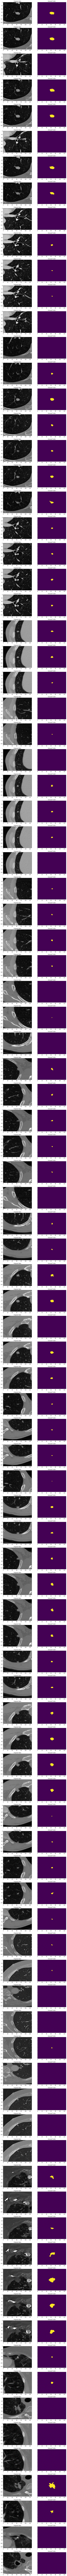

In [59]:
# number_dataset = dataset.__len__() # 45288
number_dataset = 100
fig, ax = plt.subplots(number_dataset,2, sharey=True, figsize=(12,5*number_dataset))
for i in range(number_dataset):
    image, label, series_uid = dataset.__getitem__(i)
    image_np = image.numpy()[0]
    label_np = label.numpy()
    ax[i][0].set_title("Original data")
    ax[i][1].set_title("Ground Truth")
    ax[i][0].imshow(image_np, aspect="auto",  cmap="gray" )
    # ax[0].imshow(image_np, aspect="auto")
    ax[i][1].imshow(label_np, aspect="auto")

## 用训练好的模型进行预测

In [92]:
model = ProbabilisticUnet(input_channels=1, num_classes=1, num_filters=[32,64,128,192], latent_dim=2, no_convs_fcomb=4, beta=10.0)
net = load_model(model=model, path='model/unet.pt', device=device)

In [94]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0)
epochs = 10  # 训练周期

# training
for epoch in range(epochs):
    print("Epoch {}".format(epoch))
    for step, (patch, mask, _) in enumerate(train_loader): 
        patch = patch.to(device)
        mask = mask.to(device)
        mask = torch.unsqueeze(mask,1)
        net.forward(patch, mask, training=False)
        
        
        
#         elbo = net.elbo(mask)
#         reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
#         loss = -elbo + 1e-5 * reg_loss
#         if step%100 == 0:
#             print("-- [step {}] reg_loss: {}, loss: {}".format(step, reg_loss, loss))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

Epoch 0
-- [step 0] reg_loss: 357.8720397949219, loss: 96.48130798339844


/home/jinghan/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


-- [step 100] reg_loss: 357.0701904296875, loss: 643.6050415039062


KeyboardInterrupt: 